In [10]:
import os
import rasterio
import numpy as np


/home/biswajitrana/.local/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


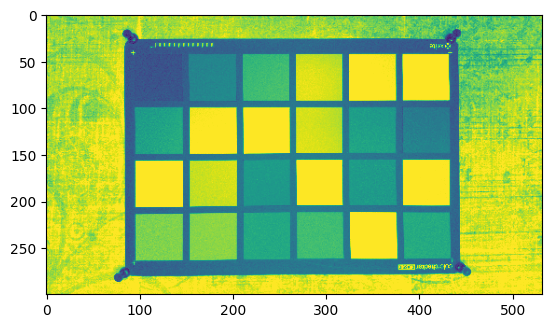

<Axes: >

In [14]:
import rasterio
from rasterio.plot import show

# Define the path to the image file
image_path = '/home/biswajitrana/Downloads/Data/Noisy_Data/0003_NOISY_SRGB_010.PNG'  # Change the file format accordingly

# Define the desired matrix size
desired_width = 532
desired_height = 300

# Open the image file with the desired size
with rasterio.open(image_path) as src:
    # Read the image data with the specified size
    image = src.read(
        out_shape=(src.count, desired_height, desired_width),
        resampling=rasterio.enums.Resampling.nearest
    )

# Plot the image
show(image)


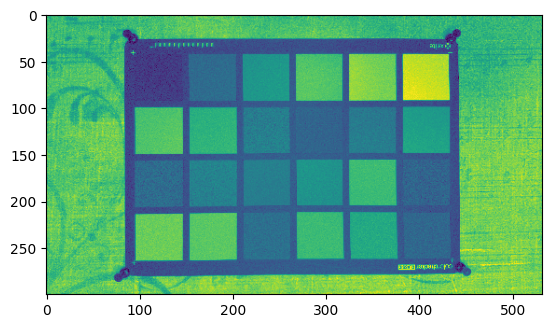

<Axes: >

In [16]:
show(image[2,:,:])

In [12]:
image.shape

(3, 300, 532)

In [9]:
import os
import cv2
import numpy as np

# Directory containing the images
directory = "/home/biswajitrana/Downloads/Data/Noisy_Data/"

# List to store matrices of all images
image_matrices = []

# Iterate through each image file
for filename in os.listdir(directory):
    if filename.endswith(".PNG"):  # Assuming images are in PNG format
        file_path = os.path.join(directory, filename)
        image = cv2.imread(file_path, cv2.IMREAD_COLOR)  # Load image in color mode
        if image is not None:
            image = cv2.resize(image, (532, 300))  # Resize image to (532, 300)
            image_matrices.append(image)

# Combine all matrices into a single array if there are images
if image_matrices:
    combined_array = np.stack(image_matrices)
    # Verify shape of the combined array
    print("Shape of Combined Array:", combined_array.shape)
else:
    print("No images found or all images failed to process.")


Shape of Combined Array: (320, 300, 532, 3)


In [13]:
flattened_combined_arr = combined_array.reshape(320, -1, 3)

# Verify the shape of the reshaped matrix
print("Shape of the reshaped matrix:", flattened_combined_arr.shape)

Shape of the reshaped matrix: (320, 159600, 3)


In [17]:
extracted_matrix = flattened_combined_arr[:, :, 0]

# Save the remaining dimensions into another matrix
other_matrix = flattened_combined_arr[:, :, 1:]

# Verify the shapes of the extracted and other matrices
print("Shape of extracted_matrix:", extracted_matrix.shape)
print("Shape of other_matrix:", other_matrix.shape)

Shape of extracted_matrix: (320, 159600)
Shape of other_matrix: (320, 159600, 2)


In [18]:
extracted_matrix.shape

(320, 159600)